In [3]:
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
import wandb

In [4]:
### taken from https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
w = h = 5
n_states = h*w
min_max_diff = 0.0001
obstacles=[(2, 2), (3, 2)]
# 0 = right, 1 = down, 2 = left, 3 = up
p = np.zeros([h, w, 4, 5])
# Normally go right with 80% probability
p[:, :, 0, 0] = 0.8
# Down
p[:, :, 1, 1] = 0.8
# Left
p[:, :, 2, 2] = 0.8
# Up
p[:, :, 3, 3] = 0.8
# Add unintentional sideways movement
p[:, :, 0, 1] = p[:, :, 0, 3] = 0.05
# Down
p[:, :, 1, 0] = p[:, :, 1, 2] = 0.05
# Left
p[:, :, 2, 1] = p[:, :, 2, 3] = 0.05
# Up
p[:, :, 3, 2] = p[:, :, 3, 0] = 0.05
# Add walls and obstacles
# Right
p[:, 4, :, 0] = p[2:4, 1, :, 0] = 0
# Down
p[4, :, :, 1] = p[1, 2, :, 1] = 0
# Left
p[:, 0, :, 2] = p[2:4, 3, :, 2] = 0
# Up
p[0, :, :, 3] = p[4, 2, :, 3] = 0
# Always stay still in the terminal state
p[4, 4, :, :] = 0
# Update stationary probs
p[:, :, :, 4] = 1-np.sum(p, axis=3)

# Now do rewards
R = np.zeros([h, w], dtype=np.float)
R[4, 4] = 10
R[4, 2] = -10

/tmp/ipykernel_15276/1708560058.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  R = np.zeros([h, w], dtype=np.float)


In [6]:
def reset_vals():
  w = h = 5
  n_states = h*w
  min_max_diff = 0.0001
  obstacles=[(2, 2), (3, 2)]
  # 0 = right, 1 = down, 2 = left, 3 = up
  p = np.zeros([h, w, 4, 5])
  # Normally go right with 80% probability
  p[:, :, 0, 0] = 0.8
  # Down
  p[:, :, 1, 1] = 0.8
  # Left
  p[:, :, 2, 2] = 0.8
  # Up
  p[:, :, 3, 3] = 0.8
  # Add unintentional sideways movement
  p[:, :, 0, 1] = p[:, :, 0, 3] = 0.05
  # Down
  p[:, :, 1, 0] = p[:, :, 1, 2] = 0.05
  # Left
  p[:, :, 2, 1] = p[:, :, 2, 3] = 0.05
  # Up
  p[:, :, 3, 2] = p[:, :, 3, 0] = 0.05
  # Add walls and obstacles
  # Right
  p[:, 4, :, 0] = p[2:4, 1, :, 0] = 0
  # Down
  p[4, :, :, 1] = p[1, 2, :, 1] = 0
  # Left
  p[:, 0, :, 2] = p[2:4, 3, :, 2] = 0
  # Up
  p[0, :, :, 3] = p[4, 2, :, 3] = 0
  # Always stay still in the terminal state
  p[4, 4, :, :] = 0
  # Update stationary probs
  p[:, :, :, 4] = 1-np.sum(p, axis=3)

  # Now do rewards
  R = np.zeros([h, w], dtype=np.float)
  R[4, 4] = 10
  R[4, 2] = -10
  return p, R

In [7]:
unicodes = ['\u2192', '\u2193', '\u2190', '\u2191']

In [8]:
def display_vals(policy, v, n, has_terminal_gold=False):
  print(color.BOLD + "Value Function:" + color.END)
  for row_values in v:
    for value in row_values:
      print("{:.4f}".format(value), end='\t')
    print()
  print()
  print(color.BOLD + "Policy:" + color.END)
  for (row, actions) in enumerate(policy):
    for (col, action) in enumerate(actions):
      char = unicodes[action] if (row, col) not in obstacles else ' '
      if row == col == 4 or (row == 0 and col == 2 and has_terminal_gold): char = 'G' 
      print(char, end='\t')
    print()
  print()
  print(n)

In [9]:
# possible_starts = [i for i in range(25) if i not in (12, 17, 24)]
possible_starts = [0]
d_0 = np.array(possible_starts)

In [10]:
def get_trajectory(policy, env, stochastic=False, state_action=False):
  # Select first state for n agents
  # s = np.random.choice(d_0, size=n)
  # state_trajectories = np.zeros([n, 100])
  # reward_trajectories = np.zeros([n, 100])
  if env == "gridworld":
    states = []
    rewards = []
    if state_action:
      actions = []
    s = np.random.choice(d_0)
    row = s // 5
    col = s % 5
    states.append((row, col))
    while True:
      if not stochastic:
        attempted_direction = policy[row, col]
      else:
        attempted_direction = np.nonzero(np.random.multinomial(1, policy[row, col]))[0][0]
      movement_probs = p[row, col, attempted_direction]
      # ??? What is this [0] at the end?
      move = np.nonzero(np.random.multinomial(1, movement_probs))[0]
      if move == 0: 
        col += 1
      elif move == 1: 
        row += 1
      elif move == 2: 
        col -= 1
      elif move == 3: 
        row -= 1
      rewards.append(R[row, col])
      states.append((row, col))
      if state_action:
        actions.append(attempted_direction)
      if row == col == 4:
        rewards.append(0)
        if state_action:
          actions.append(0)
        if state_action:
          return states, actions, rewards
        return states, rewards
  else:
    MAX_STEPS = 1000
    if len(policy.shape) >= 4: # Assuming that policies are [states]x[actions].
      print("Parallelization not yet implemented")
      return None
    n_bins = int(len(policy))
    x_bins = np.linspace(-1.2, 0.5, n_bins+1)
    v_bins = np.linspace(-0.07, 0.07, n_bins+1)
    states, rewards = [], []
    if state_action:
      actions = []
    x, v = np.squeeze(np.random.uniform(-0.4, -0.6, size=1)), 0
    for step in range(1000):
      # TODO: I will still need to check the correctness of this later
      # TODO modify this to be one dimensional and return states and rewards
      x_binned = np.digitize(x, x_bins) - 1
      v_binned = np.digitize(v, v_bins) - 1
      states.append((x_binned, v_binned))
      a = np.nonzero(np.random.multinomial(1, policy[x_binned, v_binned]))[0][0]
      if state_action:
        actions.append(a)
      # XXX I guess treating action 0 as going back?
      a = a*2-1
      v = np.where(x == 0.5, 0, np.clip(v + 0.001*a -0.0025*np.cos(3*x), -0.07, 0.07))
      x = np.where(x == 0.5, 0.5, np.clip(x + v, -1.2, 0.5))
      if x == 0.5:
        rewards.append(0)
        if state_action:
          return states, actions, rewards
        else:
          return states, rewards
      rewards.append(-1)
    if state_action:
      return states, actions, rewards
    else:
      return states, rewards 

In [11]:
def evaluate(policy, method, true_values, max_diff, every_visit = False, alpha=0.1):
  # Remember, not doing this for mountaincar (what policy would we input?)
  state_values = np.zeros([5, 5])
  num_visits = np.zeros([5, 5])
  GAMMA = 0.9
  i=0
  while True:
    states, rewards = get_trajectory(policy, "gridworld")
    if method == "mc":
      returns = np.zeros(len(states))
      nth_visit_returns = np.zeros([5, 5])
      visits = np.zeros([5, 5])
      for idx in range(len(states)-2, -1, -1):
        returns[idx] = rewards[idx] + GAMMA*returns[idx+1]
      for idx, G in enumerate(returns):
        state = states[idx]
        if not visits[state] and not every_visit:
          visits[state] = 1
          nth_visit_returns[state] = G
        elif every_visit:
          nth_visit_returns[state] = nth_visit_returns[state] + G
          visits[state] += 1
      if i == 0:
        new_state_values = nth_visit_returns
      else:
        new_state_values *= num_visits
        new_state_values += nth_visit_returns
        num_visits += visits
        new_state_values = np.where(num_visits, new_state_values/num_visits, np.zeros_like(new_state_values))
  #       new_state_values = np.where(visits, np.where(num_visits, (state_values*num_visits + nth_visit_returns)/(num_visits+1), nth_visit_returns), state_values)
  #       new_state_values = np.where(visits, np.where(num_visits, (state_values*num_visits + nth_visit_returns)/(num_visits+1), nth_visit_returns/visits), state_values)
    elif method == "td":
      # TODO could try iterating backwards
      for idx, (state, reward) in enumerate(zip(states, rewards)):
        if idx == len(states)-1:
          state_values[state] = (1-alpha)*state_values[state] + alpha*reward
        else:
          state_values[state] = (1-alpha)*state_values[state] + alpha*(GAMMA*state_values[states[idx+1]] + reward)
        new_state_values = state_values
    else:
      print("DOH")
      return
    diff = new_state_values - true_values
    if np.max(np.abs(diff)) <= max_diff:
      break
    i += 1
  return i, new_state_values

In [12]:
def control(max_its, method, env, true_values=None, every_visit=False, epsilon_decay_steps=100, epsilon_decay_rate=0, alpha=0.1, epsilon=0.05, init_values=0, softmax_heat=None, n_bins=15):
  wandb.init(project="rl_test")
  wandb.config.method = method
  wandb.config.env = env
  wandb.config.alpha = alpha
  episode_lengths = np.zeros(max_its)
  if env == "gridworld":
    num_visits = np.zeros([5, 5, 4])
    GAMMA = 0.9
    q = np.full([5, 5, 4], init_values, dtype=np.float)
    policy = np.zeros([5, 5, 4]) + 0.25
  else:
    num_visits = np.zeros([n_bins, n_bins, 2])
    q = np.full([n_bins, n_bins, 2], init_values, dtype=np.float)
    policy = np.zeros([n_bins, n_bins, 2]) + 0.5
    GAMMA = 1
  # I think even my deterministic policies will be multidimensional in action space
  stochastic = True
  if true_values is not None:
    errors = np.zeros([max_its])
  for i in range(max_its):
    policy_unsqueezed = np.expand_dims(policy, axis=2)
    q_unsqueezed = np.expand_dims(q, axis=-1)
    v = np.squeeze(policy_unsqueezed @ q_unsqueezed)
    wandb.log({"v": v[0, 0]})
    
    
    # Get a trajectory and update our q function
    states, actions, rewards = get_trajectory(policy, env, stochastic=stochastic, state_action=True)
    returns = np.zeros(len(states))
    nth_visit_returns = np.zeros([5, 5, 4])
    visits = np.zeros([5, 5, 4])
    for idx in range(len(states)-2, -1, -1):
      returns[idx] = rewards[idx] + GAMMA*returns[idx+1]
    wandb.log({"return": returns[0]})
      
    if method == "mc":
      returns = np.zeros(len(states))
      nth_visit_returns = np.zeros([5, 5, 4])
      visits = np.zeros([5, 5, 4])
      for idx in range(len(states)-2, -1, -1):
        returns[idx] = rewards[idx] + GAMMA*returns[idx+1]
      for idx, G in enumerate(returns):
        state = states[idx]
        action = actions[idx]
        if not visits[state][action] and not every_visit:
          nth_visit_returns[state][action] = G
          visits[state][action] += 1
        elif every_visit:
          nth_visit_returns[state] = nth_visit_returns[state] + G
          visits[state][action] += 1
      q *= num_visits
      q += nth_visit_returns
      num_visits += visits
      q = np.where(num_visits, q/num_visits, np.zeros_like(q))
    elif method in ("sarsa", "q_learning"):
      for idx, (state, action, reward) in enumerate(zip(states, actions, rewards)):
#         print(state, action, reward)
        if idx == len(states)-1:
          q[state][action] = (1-alpha)*q[state][action] + alpha*reward
        else:
          if method == "sarsa":
            next_val = q[states[idx+1]][actions[idx+1]]
          else:
            next_val = np.max(q[states[idx+1]])
          q[state][action] = (1-alpha)*q[state][action] + alpha*(GAMMA*next_val + reward)
    else:
      print("DOH")
      return
    # Now we have a q updated based on our last trajectory, so we should use it to update our policy
    # Figuring it's faster to just do the whole policy in one batch rather than with a for loop over the states we saw
#     print(q)
    if ((i+1)%250 == 0):
      print(q)
    if softmax_heat is None:
      # Could be deterministic if epsilon = 0
      for state in states:
        n_actions = q.shape[2]
        best_action = np.argmax(q[state])
        policy[state] = epsilon/n_actions
        policy[state][best_action] = 1 - epsilon + epsilon/n_actions
    elif softmax_heat is not None:
      # Assuming softmax
      q_heated = q*softmax_heat
      q_exp = np.exp(q_heated-np.max(q_heated, axis=-1, keepdims=True))
      policy = q_exp/np.sum(q_exp, axis=-1, keepdims=True)
      
    # Update summary variables
    # XXX could do len + 1 here, probably not a big diff
#     policy_unsqueezed = np.expand_dims(policy, axis=2)
#     q_unsqueezed = np.expand_dims(q, axis=-1)
#     v = np.squeeze(policy_unsqueezed @ q_unsqueezed)
#     print(q)
#     display_vals(np.argmax(policy, axis=-1), v, i)
    episode_lengths[i] = len(states)
    if i%1 == 0 and true_values is not None:
      policy_unsqueezed = np.expand_dims(policy, axis=2)
      q_unsqueezed = np.expand_dims(q, axis=-1)
      v = np.squeeze(policy_unsqueezed @ q_unsqueezed)
      errors[i] = ((v - true_values)**2).mean()
    if epsilon_decay_rate and (i+1)%epsilon_decay_steps == 0:
      epsilon *= epsilon_decay_rate
  if method == "q_learning":
    for state in list(itertools.product(range(5), range(5))):
        best_action = np.argmax(q[state])
        policy[state] = 0
        policy[state][best_action] = 1
  policy_unsqueezed = np.expand_dims(policy, axis=2)
  q_unsqueezed = np.expand_dims(q, axis=-1)
  v = np.squeeze(policy_unsqueezed @ q_unsqueezed)
  if true_values is not None:
    return policy, q, v, errors, episode_lengths
  else:
    return policy, q, v, episode_lengths

In [14]:
policy, q, v, _ = control(10000, "sarsa", "gridworld")
display_vals(np.argmax(policy, axis=-1), v, 10000)

return,█▇█▆▇▆▄█▇▄▇▇▄▇▅▄▇██▄▇▇▇▃██▃█▆▁▇▇▆▇▇▇█▇▄▇
v,▁▄▅▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇
return,3.8742
v,3.82315


/tmp/ipykernel_15276/2295935202.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  q = np.full([5, 5, 4], init_values, dtype=np.float)


[[[ 3.00080817e+00  3.32782460e-02  4.12086521e-01  8.91163647e-01]
  [ 3.70714439e+00  1.93819400e-01  5.72462039e-01  8.81021216e-01]
  [ 4.29689419e+00  3.67704934e-01  4.97122288e-01  9.81029185e-01]
  [ 4.80710295e+00  9.82524246e-01  2.71593864e-01  9.47681204e-01]
  [ 8.87931045e-01  5.05870686e+00  1.20856098e+00  4.68398319e-01]]

 [[ 2.27947613e-01  0.00000000e+00  9.70876673e-02  1.14680947e+00]
  [ 2.33746058e+00  0.00000000e+00  1.95295078e-01  0.00000000e+00]
  [ 4.69194760e+00  3.95308745e-01  8.12716580e-05  0.00000000e+00]
  [ 5.07757411e+00  0.00000000e+00  0.00000000e+00  3.94397336e-01]
  [ 8.75463643e-01  6.92433664e+00  6.96075554e-01  1.57649674e+00]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 5.57748028e+00  2.78915690e-02  3.12076443e-01  0.00000000e+00]
  [ 1.85799303e+00  8.40330563e+00  1.683383

In [103]:
# def plot_errors(errors, title):
#   plt.plot(range(0, len(errors)*250, 250), errors, label=title)
#   plt.legend(loc="upper right")
# #   plt.ylim((-1000,0))
# #   plt.yticks(np.arange(-1000, 0, 100))
#   plt.grid(axis="y", linestyle="dotted")
#   plt.show()

In [449]:
batch_episode_lengths_grid_es_new = np.zeros([20, 2000])
batch_errors_grid_es_new = np.zeros([20, 2000])
for i in range(20):
  policy_new, q, v, errors, episode_lengths = control(2000, "sarsa", "gridworld", true_values=optimal_values, epsilon=0.1, init_values=0, alpha=0.05)
  batch_episode_lengths_grid_es_new[i] = episode_lengths
  batch_errors_grid_es_new[i] = errors

In [445]:
episode_starts_grid_es = np.cumsum(batch_episode_lengths_grid_es, axis=1)
episode_by_time_grid_es = np.zeros([20, np.int(np.max(episode_starts_grid_es))], np.int64)
for trial in range(20):
  eps_so_far = 0
  for t in range(episode_by_time_grid_es.shape[1]):
    if eps_so_far < 20000 and t == episode_starts_grid_es[trial][eps_so_far]:
      eps_so_far += 1
    episode_by_time_grid_es[trial][t] = eps_so_far

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

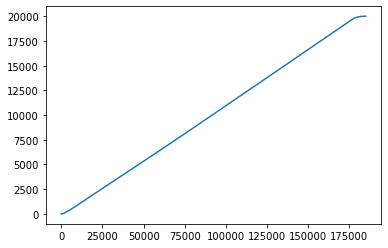

In [446]:
ave_episode_by_time_grid_es = np.mean(episode_by_time_grid_es, axis=0)
plt.plot(range(len(ave_episode_by_time_grid_es)), ave_episode_by_time_grid_es)
plt.imshow

In [451]:
episode_starts_grid_es = np.cumsum(batch_episode_lengths_grid_es_new, axis=1)
episode_by_time_grid_es = np.zeros([20, np.int(np.max(episode_starts_grid_es))], np.int64)
for trial in range(20):
  eps_so_far = 0
  for t in range(episode_by_time_grid_es.shape[1]):
    if eps_so_far < 2000 and t == episode_starts_grid_es[trial][eps_so_far]:
      eps_so_far += 1
    episode_by_time_grid_es[trial][t] = eps_so_far

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

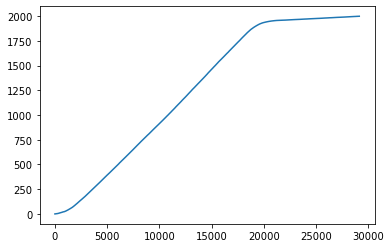

In [452]:
ave_episode_by_time_grid_es = np.mean(episode_by_time_grid_es, axis=0)
plt.plot(range(len(ave_episode_by_time_grid_es)), ave_episode_by_time_grid_es)
plt.imshow

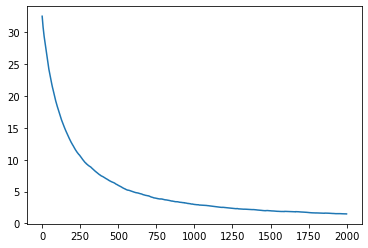

In [463]:
plt.plot(range(2000), np.mean(batch_errors_grid_es_new, axis=0))

In [444]:
display_vals(np.argmax(policy, axis=-1), v, 1000)

Value Function:
3.6407	4.2150	4.8178	5.3804	6.1661	
4.0500	4.6246	5.3360	6.1330	7.2978	
3.5527	4.0304	0.0000	7.1752	8.2691	
3.0471	3.3302	0.0000	8.2829	9.3563	
2.5628	2.0502	6.1040	8.7521	0.0000	

Policy:
→	→	→	↓	↓	
→	→	→	→	↓	
→	↑	 	↓	↓	
↑	↑	 	→	↓	
↑	←	→	→	G	

1000


In [458]:
batch_episode_lengths_grid_eq = np.zeros([20, 2000])
batch_errors_grid_eq = np.zeros([20, 2000])
for i in range(20):
  policy, q, v, errors, episode_lengths = control(2000, "q_learning", "gridworld", true_values=optimal_values, epsilon=0.1, init_values=0, alpha=0.05)
  batch_episode_lengths_grid_eq[i] = episode_lengths
  batch_errors_grid_eq[i] = errors

In [460]:
episode_starts_grid_eq = np.cumsum(batch_episode_lengths_grid_eq, axis=1)
episode_by_time_grid_eq = np.zeros([20, np.int(np.max(episode_starts_grid_eq))], np.int64)
for trial in range(20):
  eps_so_far = 0
  for t in range(episode_by_time_grid_eq.shape[1]):
    if eps_so_far < 2000 and t == episode_starts_grid_eq[trial][eps_so_far]:
      eps_so_far += 1
    episode_by_time_grid_eq[trial][t] = eps_so_far

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

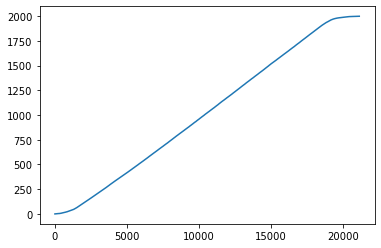

In [461]:
ave_episode_by_time_grid_eq = np.mean(episode_by_time_grid_eq, axis=0)
plt.plot(range(len(ave_episode_by_time_grid_eq)), ave_episode_by_time_grid_eq)
plt.imshow

In [ ]:
batch_episode_lengths_grid_es = np.zeros([20, 20000])
batch_errors_grid_es = np.zeros([20, 20000])
for i in range(20):
  policy, q, v, errors, episode_lengths = control(20000, "sarsa", "gridworld", true_values=optimal_values, epsilon=0.1, init_values=0, alpha=0.05)
  batch_episode_lengths_grid_es[i] = episode_lengths
  batch_errors_grid_es[i] = errors

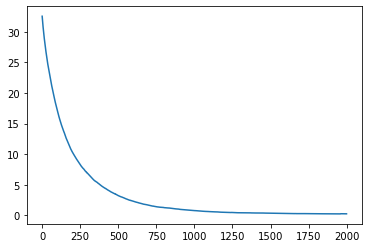

In [464]:
plt.plot(range(2000), np.mean(batch_errors_grid_eq, axis=0))

In [465]:
display_vals(np.argmax(policy, axis=-1), v, 1000)

Value Function:
3.8591	4.3639	5.0699	5.8530	6.4775	
4.3515	4.9801	5.8143	6.6665	7.6225	
3.7976	4.3941	0.0000	7.4314	8.5688	
3.4090	3.8364	0.0000	8.4758	9.8639	
2.9934	2.5254	6.8470	9.6962	0.0000	

Policy:
→	↓	→	↓	↓	
→	→	→	→	↓	
→	↑	 	→	↓	
↑	↑	 	→	↓	
↑	←	→	→	G	

1000


In [470]:
policy, q, v, errors, episode_lengths = control(2000, "q_learning", "gridworld", true_values=optimal_values, epsilon=0.1, init_values=0, alpha=0.05)

In [471]:
display_vals(np.argmax(policy, axis=-1), v, 1000)

Value Function:
3.8056	4.2881	5.0244	5.7556	6.4126	
4.3168	4.8697	5.5571	6.4131	7.2743	
3.8478	4.3011	0.0000	7.6775	8.4984	
3.3937	3.7883	0.0000	8.6760	9.7435	
2.9621	2.3775	7.2378	9.8083	0.0000	

Policy:
→	↓	↓	→	↓	
→	→	→	→	↓	
→	↑	 	↓	↓	
↑	↑	 	↓	↓	
↑	←	→	→	G	

1000


In [164]:
policy, q, v, errors, episode_lengths = control(1000, "q_learning", "gridworld", true_values=optimal_values, softmax_heat=1, init_values=0, alpha=0.1)

In [165]:
display_vals(np.argmax(policy, axis=-1), v, 1000)

Value Function:
3.6611	4.5088	5.1994	5.7363	6.4854	
4.2968	4.9806	5.9236	6.8907	7.7409	
3.8985	4.3962	0.0000	7.7553	8.6112	
3.4342	3.8695	0.0000	8.6703	9.8551	
2.7967	3.3147	6.5671	9.8222	0.0000	

Policy:
↓	→	↓	↓	↓	
→	→	→	↓	↓	
→	↑	 	↓	↓	
↑	↑	 	↓	↓	
↑	↑	→	→	G	

1000


In [172]:
policy, q, v, errors, episode_lengths = control(1000, "q_learning", "gridworld", true_values=optimal_values, epsilon=0.1, init_values=100, alpha=0.1)

In [173]:
display_vals(np.argmax(policy, axis=-1), v, 1000)

Value Function:
13.0000	14.0000	18.0000	27.0000	40.0000	
13.0000	15.0000	27.0000	40.0000	54.0000	
15.0000	18.0000	100.0000	55.0000	72.0000	
22.0000	31.0000	100.0000	72.0000	91.0000	
31.0000	45.0000	72.0000	91.0000	100.0000	

Policy:
↓	→	↓	→	↓	
↓	↑	→	↓	↓	
→	↓	 	↓	↓	
↓	↓	 	↓	↓	
→	→	→	→	G	

1000


In [259]:
policy, q, v, episode_lengths = control(1000, "sarsa", "mountain_car", epsilon=0.1, init_values=0, alpha=0.1)

[[[-137.75062868 -137.16001069]
  [-147.54454611 -145.7862742 ]
  [-146.85976994 -154.18821844]
  [-118.7049948   -99.32651647]
  [ -57.64041961  -57.65378949]]

 [[-160.36268285 -169.75741337]
  [-276.33870019 -304.58744392]
  [-357.45499761 -328.30454241]
  [-161.56340663 -162.18203327]
  [ -67.79114912  -63.32827005]]

 [[-144.97773128 -146.03608577]
  [-245.66195828 -266.41541926]
  [-316.9370554  -356.03914485]
  [-201.8599455  -195.42765459]
  [ -73.75018282  -48.22690401]]

 [[ -99.20399249 -102.43042624]
  [-170.71970083 -176.83634357]
  [-167.60306386 -184.93446718]
  [-129.50559526 -111.42151425]
  [ -58.31853401  -31.68587253]]

 [[   0.            0.        ]
  [-111.49080324 -110.7879292 ]
  [ -93.72661531  -91.53262287]
  [ -38.86940369  -29.79792718]
  [ -17.01989638   -9.46729077]]]
[[[-191.44327996 -191.63638391]
  [-195.68630779 -195.3175163 ]
  [-189.08303774 -192.53281746]
  [-175.52724468 -178.44025266]
  [-117.13219244 -117.41988042]]

 [[-206.19961436 -237.427542

In [262]:
print(np.argmax(policy, axis=-1), v, 1000, sep="\n")

[[1 1 1 1 1]
 [1 0 1 1 1]
 [0 0 0 1 1]
 [1 0 0 0 1]
 [0 0 1 1 1]]
[[-255.66082521 -261.10315052 -253.69853021 -201.89543559 -135.38023654]
 [-260.02669031 -400.28569503 -449.85187421 -247.79360445 -124.08242861]
 [-263.94602822 -358.44394134 -496.05766506 -260.61555371 -120.25180944]
 [-253.89801226 -313.09121972 -324.05815219 -217.72706762  -93.80708224]
 [   0.         -278.36664303 -222.55628804  -80.9365409   -19.18509079]]
1000


In [263]:
episode_lengths

array([1000., 1000., 1000., 1000., 1000., 1000., 1000.,  553.,  182.,
       1000.,  553.,  454., 1000.,  106., 1000.,  687., 1000., 1000.,
        775.,  397.,  491., 1000.,  826., 1000., 1000., 1000., 1000.,
        165.,  452., 1000., 1000.,  735.,  610., 1000.,  179.,  633.,
        419.,  610., 1000., 1000., 1000., 1000.,  525.,  648.,  486.,
        165., 1000., 1000.,  296., 1000.,  316.,  140.,  644.,  227.,
        282.,  975., 1000.,  688.,  674.,  426., 1000.,  442., 1000.,
        136.,  541., 1000., 1000.,  614., 1000., 1000., 1000.,  343.,
       1000.,  954., 1000., 1000.,  492.,  281.,  213., 1000., 1000.,
        170., 1000.,  321.,  320.,  147.,  479., 1000., 1000.,  307.,
        433.,  167.,  214.,  387., 1000.,  136., 1000.,  131., 1000.,
        595.,  752., 1000.,  337.,  195.,  175.,  515.,  712.,  170.,
        177.,  912.,  262.,  659.,  198.,  600.,  346., 1000.,  811.,
        209.,  400.,  473., 1000., 1000., 1000., 1000.,  227.,  690.,
       1000.,  159.,

In [264]:
policy, q, v, episode_lengths = control(1000, "q_learning", "mountain_car", epsilon=0.1, init_values=0, alpha=0.1)

[[[ -63.53656011  -64.03750485]
  [ -72.09203985  -71.98247963]
  [ -71.39856735  -69.03878202]
  [ -62.92321069  -62.65575601]
  [ -40.43910644  -40.49907734]]

 [[ -72.49770845  -73.43582658]
  [ -94.89938731  -96.76773714]
  [-110.22844748 -110.14117917]
  [ -77.07459591  -72.33537528]
  [ -47.20023017  -44.69221866]]

 [[ -68.07354193  -67.93307121]
  [ -91.28833921  -92.68241491]
  [-104.60965911 -105.27728496]
  [ -88.04976762  -78.79790272]
  [ -45.74974948  -43.47339885]]

 [[ -47.6354717   -48.46110038]
  [ -72.63427757  -74.92802383]
  [ -77.57878979  -78.40956753]
  [ -52.35802527  -49.53067242]
  [ -34.57498061  -33.13459991]]

 [[   0.            0.        ]
  [ -41.51289933  -43.48578303]
  [ -46.19808165  -42.90850979]
  [ -22.61882265  -15.97090816]
  [  -8.59231253   -7.31373812]]]
[[[ -93.64145625  -93.77204236]
  [ -94.56394938  -93.7627601 ]
  [ -93.87365849  -89.50287711]
  [ -83.8834422   -74.9719354 ]
  [ -57.49434169  -57.55171486]]

 [[-101.2770502  -105.022279

In [265]:
v

array([[-118.96704796, -120.16478964, -119.08760514,  -95.28548183,
         -75.49573216],
       [-127.84302843, -146.44211414, -136.76580684, -130.36568239,
         -77.45622963],
       [-130.84192036, -146.45426792, -154.6574566 , -132.38629692,
         -68.13683784],
       [-123.46868093, -144.64494153, -147.28035596,  -99.07841258,
         -43.12641826],
       [   0.        , -126.30470418,  -84.82441263,  -47.68734991,
         -12.19942162]])

In [266]:
episode_lengths

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000.,  499.,  261., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000.,  116.,  450., 1000.,
       1000., 1000., 1000.,  329., 1000.,  186., 1000.,  150.,  188.,
        184., 1000., 1000.,  817., 1000.,  329., 1000., 1000., 1000.,
       1000., 1000., 1000.,  520., 1000., 1000., 1000., 1000.,  925.,
       1000.,  495.,  972.,  214.,  384.,  640.,  826., 1000.,  725.,
       1000., 1000.,  544., 1000.,  473., 1000., 1000., 1000.,  737.,
       1000., 1000.,  814.,  415.,  146.,  209., 1000., 1000., 1000.,
        563.,  669., 1000., 1000., 1000., 1000.,  178.,  289.,  323.,
        251.,  576.,  888.,  952.,  298.,  860.,  861., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000.,  235.,  684., 1000.,  347.,
        368.,  227.,  288., 1000.,   95.,  197., 1000.,  523., 1000.,
        334., 1000.,  650., 1000.,  170.,  289.,  136., 1000., 1000.,
       1000., 1000.,

In [267]:
policy, q, v, episode_lengths = control(10000, "q_learning", "mountain_car", epsilon=0.05, init_values=5, alpha=0.1)

[[[-48.02180169 -47.77252325]
  [-58.48909656 -57.9853123 ]
  [-57.53389151 -55.52848691]
  [-45.34058905 -44.14587931]
  [-30.31009364 -30.63888292]]

 [[-49.88176422 -49.38991191]
  [-77.51209819 -80.41653027]
  [-88.42136736 -86.32698719]
  [-57.68153979 -57.63468745]
  [-36.08458878 -35.97173279]]

 [[-47.95257124 -47.64168824]
  [-74.43594706 -75.58999875]
  [-89.37658976 -91.16853528]
  [-64.10440459 -65.47106965]
  [-34.48369669 -32.1988954 ]]

 [[-33.47322013 -33.62138372]
  [-47.67110046 -50.57919111]
  [-63.32088358 -61.90020904]
  [-40.71128022 -32.89090035]
  [-27.90374778 -26.74708803]]

 [[  5.           5.        ]
  [-32.4884471  -33.24167444]
  [-29.56266553 -30.72600632]
  [-17.63775413 -14.26279888]
  [ -7.20920568  -5.91441217]]]
[[[ -83.97548711  -83.53849445]
  [ -85.90560669  -85.94312077]
  [ -84.39162106  -80.29003286]
  [ -72.23739455  -68.14120359]
  [ -43.04385481  -42.00544103]]

 [[ -87.28298507  -89.59578759]
  [-112.66388779 -115.40730419]
  [-123.280200

In [274]:
np.mean(episode_lengths[500:1000])

678.668

In [323]:
policy, q, v, episode_lengths = control(1000, "sarsa", "mountain_car", epsilon=0.05, init_values=5, alpha=0.05, n_bins=15)

In [325]:
q

array([[[  5.        ,   4.63086651],
        [-21.22701167, -21.66967657],
        [-41.01953053, -41.02591754],
        [-42.63866641, -42.62644585],
        [-41.64236254, -41.64137353],
        [-39.81616545, -39.75571955],
        [-37.64936024, -37.66312655],
        [-35.32872191, -35.29064296],
        [-33.07747828, -32.89477812],
        [-30.50612403, -30.26554654],
        [-27.50845761, -27.46419887],
        [  5.        ,   5.        ],
        [  5.        ,   5.        ],
        [  5.        ,   5.        ],
        [  5.        ,   5.        ]],

       [[  1.95563677,   0.52764937],
        [-28.39271989, -28.71604579],
        [-39.5599244 , -39.62207751],
        [-40.38125158, -40.49846861],
        [-38.55810959, -38.53252841],
        [-37.81435506, -37.74595331],
        [-36.87993703, -36.92512109],
        [-35.96709678, -35.95302641],
        [-34.568625  , -34.71165196],
        [-31.29432993, -31.59049592],
        [-29.2862363 , -29.06681285],
        [-

In [324]:
episode_lengths

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000.,  671., 1000.,  847.,
       1000., 1000., 1000., 1000.,  735.,  163., 1000., 1000.,  284.,
        486., 1000.,  337., 1000.,  234.,  174., 1000.,  224., 1000.,
        236.,  734.,  275., 1000., 1000., 1000., 1000.,  259.,  259.,
       1000., 1000.,  210.,  337.,  355.,  185.,  163.,  207.,  164.,
        172.,  188.,  280., 1000.,  722.,  697.,  204., 1000.,  380.,
       1000.,  645., 1000.,  289.,  353.,  275., 1000., 1000., 1000.,
        443.,  260., 1000.,  245., 1000.,  219., 1000.,  349.,  239.,
        260.,  529.,  202.,  202.,  275.,  237.,  513.,  186.,  271.,
        927.,  383.,  689.,  373.,  240.,  246.,  434., 1000.,  452.,
        347.,  259.,  230., 1000., 1000.,  326.,  358.,  150.,  167.,
        264., 1000.,  406.,  173.,  275.,  584.,  172.,  826., 1000.,
        234., 1000.,  261.,  267.,  151.,  470.,  646.,  709.,  321.,
        320.,  223.,

In [336]:
policy, q, v, episode_lengths = control(500, "q_learning", "mountain_car", epsilon=0.5, epsilon_decay_steps=1, epsilon_decay_rate=0.98, init_values=5, alpha=0.05, n_bins=15)

In [325]:
q

array([[[  5.        ,   4.63086651],
        [-21.22701167, -21.66967657],
        [-41.01953053, -41.02591754],
        [-42.63866641, -42.62644585],
        [-41.64236254, -41.64137353],
        [-39.81616545, -39.75571955],
        [-37.64936024, -37.66312655],
        [-35.32872191, -35.29064296],
        [-33.07747828, -32.89477812],
        [-30.50612403, -30.26554654],
        [-27.50845761, -27.46419887],
        [  5.        ,   5.        ],
        [  5.        ,   5.        ],
        [  5.        ,   5.        ],
        [  5.        ,   5.        ]],

       [[  1.95563677,   0.52764937],
        [-28.39271989, -28.71604579],
        [-39.5599244 , -39.62207751],
        [-40.38125158, -40.49846861],
        [-38.55810959, -38.53252841],
        [-37.81435506, -37.74595331],
        [-36.87993703, -36.92512109],
        [-35.96709678, -35.95302641],
        [-34.568625  , -34.71165196],
        [-31.29432993, -31.59049592],
        [-29.2862363 , -29.06681285],
        [-

In [337]:
episode_lengths

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        456., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000.,  489.,  911., 1000., 1000.,  239.,  664.,
       1000., 1000., 1000.,  628., 1000.,  869.,  408.,  680.,  403.,
        621., 1000., 1000.,  550., 1000., 1000., 1000.,  497.,  400.,
        293.,  295.,  295.,  495.,  451.,  230., 1000.,  563.,  347.,
        586., 1000.,  629.,  359.,  459., 1000.,  376.,  852.,  455.,
        248.,  268.,  322.,  246.,  251., 1000., 1000.,  244.,  665.,
       1000.,  675., 1000.,  205.,  194.,  261.,  251.,  233.,  221.,
        282.,  244., 1000.,  215.,  288., 1000.,  603.,  247.,  301.,
        547.,  904., 1000.,  696., 1000., 1000.,  292., 1000.,  535.,
       1000.,  718., 1000.,  240.,  206., 1000.,  414.,  219.,  282.,
       1000.,  609.,  170.,  154.,  167., 1000.,  151.,  196.,  426.,
       1000.,  285., 1000.,  437.,  485.,  438.,  304., 1000.,  258.,
        476., 1000.,

In [370]:
batch_episode_lengths_softmax_q = np.zeros([20, 2000])
for i in range(20):
  policy, q, v, episode_lengths = control(2000, "q_learning", "mountain_car", softmax_heat=0.5, init_values=0, alpha=0.1, n_bins=15)
  batch_episode_lengths_softmax_q[i] = episode_lengths

In [371]:
batch_episode_lengths_epsilon_q = np.zeros([20, 2000])
for i in range(20):
  policy, q, v, episode_lengths = control(2000, "q_learning", "mountain_car", epsilon=0.05, init_values=0, alpha=0.1, n_bins=15)
  batch_episode_lengths_epsilon_q[i] = episode_lengths

In [372]:
batch_episode_lengths_softmax_sarsa = np.zeros([20, 2000])
for i in range(20):
  policy, q, v, episode_lengths = control(2000, "sarsa", "mountain_car", softmax_heat=0.5, init_values=0, alpha=0.1, n_bins=15)
  batch_episode_lengths_softmax_sarsa[i] = episode_lengths

In [373]:
batch_episode_lengths_epsilon_sarsa = np.zeros([20, 2000])
for i in range(20):
  policy, q, v, episode_lengths = control(2000, "q_learning", "mountain_car", epsilon=0.05, init_values=0, alpha=0.1, n_bins=15)
  batch_episode_lengths_epsilon_sarsa[i] = episode_lengths

In [374]:
batch_episode_lengths_softmax_q

array([[1000., 1000., 1000., ...,  281.,  176.,  262.],
       [1000.,  939., 1000., ...,   97.,  185.,  121.],
       [1000., 1000., 1000., ...,  253.,  248.,  228.],
       ...,
       [1000., 1000., 1000., ...,  181.,  233.,  208.],
       [1000., 1000., 1000., ...,  149.,  281.,  155.],
       [1000., 1000., 1000., ...,  187.,  122.,  180.]])

In [379]:
batch_episode_lengths_epsilon_q
backup_eq = batch_episode_lengths_epsilon_q

In [387]:
episode_starts_eq = np.cumsum(batch_episode_lengths_epsilon_q, axis=1)
episode_by_time_eq = np.zeros([20, np.int(np.max(episode_starts_eq))], np.int64)
for trial in range(20):
  eps_so_far = 0
  for t in range(episode_by_time_eq.shape[1]):
    if eps_so_far < 2000 and t == episode_starts_eq[trial][eps_so_far]:
      eps_so_far += 1
    episode_by_time_eq[trial][t] = eps_so_far

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

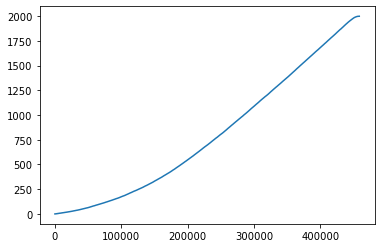

In [391]:
ave_episode_by_time_eq = np.mean(episode_by_time_eq, axis=0)
plt.plot(range(len(ave_episode_by_time_eq)), ave_episode_by_time_eq)
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

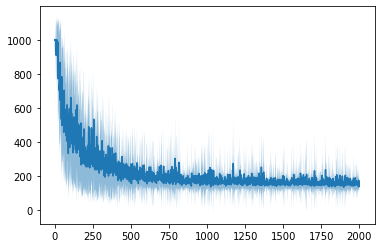

In [396]:
ave_time_per_episode_eq = np.mean(batch_episode_lengths_epsilon_q, axis=0)
std_eq = np.std(batch_episode_lengths_epsilon_q, axis=0)
plt.plot(range(2000), ave_time_per_episode_eq)
plt.fill_between(range(2000), ave_time_per_episode_eq+std_eq, ave_time_per_episode_eq-std_eq, alpha=0.5)
plt.imshow

In [376]:
batch_episode_lengths_softmax_sarsa

array([[1000., 1000., 1000., ...,  143.,  115.,  185.],
       [1000., 1000., 1000., ...,  173.,  160.,  180.],
       [1000., 1000., 1000., ...,  153., 1000.,  175.],
       ...,
       [1000., 1000., 1000., ...,  201.,  159.,  165.],
       [1000., 1000., 1000., ...,  189.,  197.,  150.],
       [1000., 1000., 1000., ...,  154.,  146.,  146.]])

In [377]:
batch_episode_lengths_epsilon_sarsa

array([[1000., 1000., 1000., ...,  157.,  157.,  177.],
       [1000., 1000., 1000., ...,  136.,  182.,  223.],
       [1000., 1000., 1000., ...,  164.,  161.,  237.],
       ...,
       [1000., 1000., 1000., ...,  136.,  151.,  130.],
       [1000., 1000., 1000., ...,  148.,  167.,  158.],
       [1000., 1000., 1000., ...,  217.,  269.,  153.]])

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

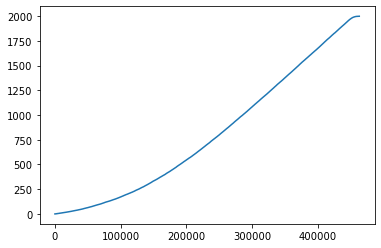

In [392]:
episode_starts_es = np.cumsum(batch_episode_lengths_epsilon_sarsa, axis=1)
episode_by_time_es = np.zeros([20, np.int(np.max(episode_starts_es))], np.int64)
for trial in range(20):
  eps_so_far = 0
  for t in range(episode_by_time_es.shape[1]):
    if eps_so_far < 2000 and t == episode_starts_es[trial][eps_so_far]:
      eps_so_far += 1
    episode_by_time_es[trial][t] = eps_so_far
ave_episode_by_time_es = np.mean(episode_by_time_es, axis=0)
plt.plot(range(len(ave_episode_by_time_es)), ave_episode_by_time_es)
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

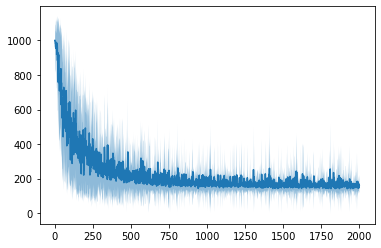

In [397]:
ave_time_per_episode_es = np.mean(batch_episode_lengths_epsilon_sarsa, axis=0)
std_es = np.std(batch_episode_lengths_epsilon_sarsa, axis=0)
plt.plot(range(2000), ave_time_per_episode_es)
plt.fill_between(range(2000), ave_time_per_episode_es+std_es, ave_time_per_episode_es-std_es, alpha=0.5)
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

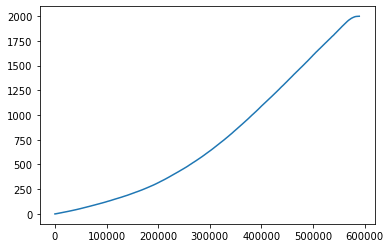

In [393]:
episode_starts_ss = np.cumsum(batch_episode_lengths_softmax_sarsa, axis=1)
episode_by_time_ss = np.zeros([20, np.int(np.max(episode_starts_ss))], np.int64)
for trial in range(20):
  eps_so_far = 0
  for t in range(episode_by_time_ss.shape[1]):
    if eps_so_far < 2000 and t == episode_starts_ss[trial][eps_so_far]:
      eps_so_far += 1
    episode_by_time_ss[trial][t] = eps_so_far
ave_episode_by_time_ss = np.mean(episode_by_time_ss, axis=0)
plt.plot(range(len(ave_episode_by_time_ss)), ave_episode_by_time_ss)
plt.imshow

In [366]:
# episode_lengths[1000:2001]

array([ 154.,  147.,  168.,  148.,  138.,  144.,  154.,  157.,  150.,
        142.,  146.,  144.,  154.,  136.,  158.,  151.,  131.,  134.,
        158.,  139.,  141.,  149.,  147.,  134.,  145.,  228.,  136.,
        243.,  170.,  236.,  221.,  140.,  230.,  235.,  231.,  223.,
        221.,  141.,  215.,  207.,  217.,  149.,  148.,  142.,  138.,
        246.,  147.,  139.,  152.,  139.,  138.,  244.,  147.,  235.,
        173.,  249.,  247.,  168.,  141.,  142.,  186.,  145.,  157.,
        159.,  251.,  158.,  256.,  153.,  141.,  130.,  282.,  156.,
        231.,  216.,  252.,  215.,  223.,  192.,  382.,  186.,  184.,
        252.,  191.,  187.,  354.,  189.,  182.,  185.,  208.,  179.,
        215.,  217.,  302.,  213.,  258.,  187.,  168.,  176.,  217.,
        211.,  187.,  200.,  181.,  181.,   95.,  210.,  173.,  197.,
        194.,  172.,  166.,  166.,  210.,  176.,  170.,  168.,  196.,
        166.,  193.,  170.,  216., 1000.,  227.,  160.,  209.,  171.,
        163.,  195.,

In [368]:
# episode_lengths[1000:2001]

array([155., 159., 171., 155., 151., 156., 155., 147., 163., 160., 160.,
       166., 143., 151., 147., 162., 154., 147., 169., 151., 147., 136.,
       155., 148., 159., 157., 152., 150., 127., 133., 150., 154., 152.,
       133., 142., 134., 136., 147., 155., 156., 137., 144., 225., 144.,
       149., 244., 216., 221., 156., 164., 169., 130., 146., 156., 220.,
       227., 152., 155., 158., 167., 143., 244., 196., 667., 293., 256.,
       141., 351., 178., 220., 160., 159., 230., 172., 157., 157., 216.,
       176., 230., 162., 161., 156., 183., 216., 208., 150., 138., 139.,
       165., 149., 162., 136., 151., 139., 145., 148., 160., 162., 346.,
       166., 168., 159., 119., 562., 253., 120., 299., 108., 133., 166.,
       161., 114., 165., 167., 164., 156., 100., 201., 146., 182., 173.,
       133., 118., 121., 215., 145., 150., 147., 165.,  90., 161., 132.,
       188., 272., 176., 152., 161., 170.,  92., 152., 155., 144., 136.,
       169., 160., 165., 161., 135., 143., 139., 13